# Example 7 - Multi-objective optimization for plug flow reactor

In this example, we will demonstrate how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front. We will use the PFR model from [example 5](05_PFR_yield.ipynb). Two output variables will be generated from the model: yield (`y1`) and selectivity (`y2`). Unfortunately, these two variables cannot be maximized simultaneously. An increase in yield would lead to a decrease in selectivity, and vice versa. 

For this example, the scalarized objective can be written as,
$$ y = w_1 y_1 + w_2 y_2 $$
where the weights $ w_1, w_2 \in [0, 1] $ and $w_1 + w_2 = 1 $.

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [1]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

In [2]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield and selectivity
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi = Reactor(**Conditions)        
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
        
    return Y_real # yield, selectivity


# Objective function
objective_func = PFR


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# two outputs
Y_name_with_unit = ['Yield %', 'Selectivity %']

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  


# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = len(Y_name_with_unit) # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


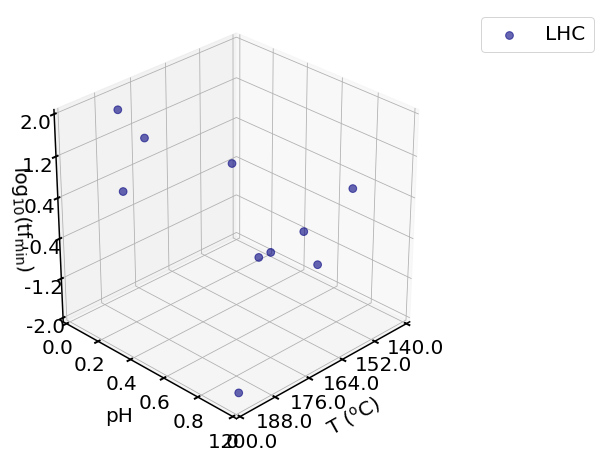

In [3]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(X_init_lhc, 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = 'LHC')

## 4. Initialize an `Experiment` object 

In this example, we use an `MOOExperiment` object, a class designed for multi-objective optimization. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `MOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`. Additionally, `weights` is required for `MOOExperiment.set_optim_specs` function. It defines a list of weights for objective 1. The weights of objective 2 is 1 minus that of objective 1. Under the hood, each weight combination correponds to a single `Experiment` object, each with a different scalarized objective. 

Some progress status will be printed out while initializing all single `Experiment` objects.

In [4]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.MOOExperiment('PFR_yield_MOO')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name_with_unit,
                   Y_names = Y_name_with_unit,
                   unit_flag = True)

# Set the optimization specifications 
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 21 # number of single Experiments

# Set a weight vector for objective 1
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True, 
                        weights = weights_obj_1)
end_time = time.time()
print('Initializing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Initializing 21 experiments
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 4.76 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 9.52 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 14.29 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 19.05 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 23.81 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 28.57 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 33.33 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.92928886

## 5. Run trials 

At each weight combinations, we perform an optimization task for the scalarized objective (a single `Experiment`). `MOOExperiment.run_exp_auto` run these tasks automatically by using the default choice of acqucision function, Expected improvement (EI). It takes in the number of trials required for each `Experiment`. The number of trials needs to be large enough which allows Bayesian Optimization algorithm to converge to the optimum. In this example, the evalution would be slow since the total number of calls for the objective function is `n_trails` * `n_exp` (=420). 

Some progress status will be printed out during the training.

In [ ]:
# Set the number of iterations for each experiments
n_trials_lhc = 20 
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print('Optimizing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Running 21 experiments
Iter 10/100: 4.183126449584961
Iter 20/100: 3.943657875061035
Iter 30/100: 3.821441411972046
Iter 40/100: 3.7874295711517334
Iter 50/100: 3.7611007690429688
Iter 60/100: 3.740879535675049
Iter 70/100: 3.726250171661377
Iter 80/100: 3.7125136852264404
Iter 90/100: 3.6984825134277344
Iter 100/100: 3.6746041774749756
Iter 10/100: 3.4573545455932617
Iter 20/100: 3.429495096206665
Iter 30/100: 3.4093880653381348
Iter 40/100: 3.394003391265869
Iter 50/100: 3.381753444671631
Iter 60/100: 3.371739387512207
Iter 70/100: 3.363407611846924
Iter 80/100: 3.3563222885131836
Iter 90/100: 3.3501975536346436
Iter 100/100: 3.344837188720703
Iter 10/100: 2.8463380336761475
Iter 20/100: 2.837150812149048
Iter 30/100: 2.82894229888916
Iter 40/100: 2.822157144546509
Iter 50/100: 2.816131114959717
Iter 60/100: 2.8108115196228027
Iter 70/100: 2.806081771850586
Iter 80/100: 2.801821231842041
Iter 90/100: 2.7979626655578613
Iter 100/100: 2.7944416999816895
Iter 10/100: 2.574374198913574
I

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `MOOExperiment` object by using `MOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The region below $ y=x $ is infeasible for the PFR model and we have no Pareto points fall below the line, incidating the method is validate. 

In [ ]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = [r'$\rm w_1$', r'$\rm w_2$'] 

# Parse the optimum into a table
data_opt = io.np_to_dataframe([weights_obj_1, weights_obj_2, X_real_opts, Y_real_opts], weight_names + var_names, n = n_exp)
display(data_opt.round(decimals=2))

# Make the pareto plots 
plotting.pareto_front_exp(Exp_lhc, fill = False)

## References:
Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model